In [1]:
# general data processing
import numpy as np

# data viz
import matplotlib.pyplot as plt

# utils
import tarfile
import pickle
import os

# pytorch framework
import torch
from torch import nn
import torchvision.transforms.functional as fn
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# huggingface transformers
from transformers import ResNetModel

# pytorch-lightning framework
import pytorch_lightning as pl

# Data Loading

In [2]:
# dataset_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
# download_url(dataset_url, '.')

# # Extract from archive
# with tarfile.open('./cifar-10-python.tar.gz', 'r:gz') as tar:
#     tar.extractall(path='./data')

'automobile'

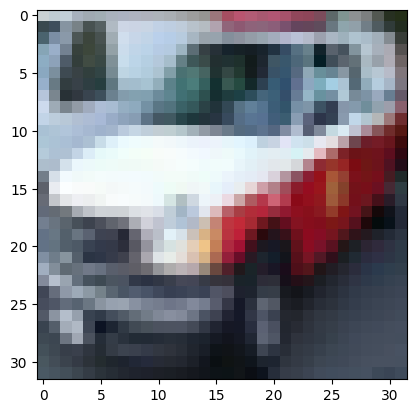

In [3]:
def unpickle(file):
    bytes2str = lambda x: x.decode('utf-8')
    with open(file, 'rb') as fo:
        _dict = pickle.load(fo, encoding='bytes')
    # transform every key from bytes to string in the keys of the dictionary
    _dict = {bytes2str(key): value for key, value in _dict.items()}
    return _dict

def get_label_text(label_idx):
    label_names = unpickle("data/cifar-10-batches-py/batches.meta")['label_names']
    return label_names[label_idx].decode('utf-8')

data = unpickle("data/cifar-10-batches-py/data_batch_1")

IMAGE_INDEX=60
image = torch.Tensor(data["data"]).reshape(10000, 3, 32, 32)
plt.imshow(image[IMAGE_INDEX].permute(1, 2, 0).numpy().astype(np.uint8))
get_label_text(data["labels"][IMAGE_INDEX])

# Data Processing

x torch.Size([30, 3, 96, 96])
y torch.Size([30, 1])
bird


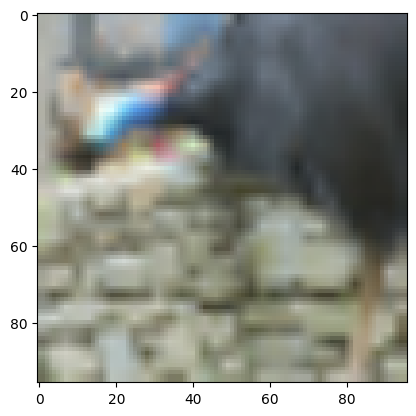

In [4]:
class ToTensor(object):
    def __call__(self, array):
        return torch.from_numpy(array).to(torch.float32)

class ReshapeAdjust(object):
    def __call__(self, tensor):
        tensor = (
            tensor
            .reshape(3, 32, 32)
        )
        tensor = fn.resize(tensor, size=[96, 96], antialias=False)
        return tensor
    
def unpickle(file):
    bytes2str = lambda x: x.decode('utf-8')
    with open(file, 'rb') as fo:
        _dict = pickle.load(fo, encoding='bytes')
    # transform every key from bytes to string in the keys of the dictionary
    _dict = {bytes2str(key): value for key, value in _dict.items()}
    return _dict


class CIFAR10(Dataset):
    def __init__(self, folderpath:str, transform=None, target_transform=None, train=True):
        self.folderpath = folderpath
        full_training_data, test_data = self.get_data_dictionary(self.folderpath)
        self.data = full_training_data if train else test_data
        self.transform = transform
        self.target_transform = target_transform

    @staticmethod
    def get_data_dictionary(folderpath:str) -> tuple:
        full_training_data = {
            "features": [],
            "labels": []
        }
        test_data = {
            "features": [],
            "labels": []
        }
        for file in os.listdir(folderpath):
            if not file.endswith(".meta") and not file.endswith(".html"):
                file = os.path.join(folderpath, file)
                data = unpickle(file)
                data = {key: value for key, value in data.items() if key in ["data", "labels"]}
                if "test" in file:
                    test_data["features"].append(data["data"])
                    test_data["labels"].append(data["labels"])
                else:
                    full_training_data["features"].append(data["data"])
                    full_training_data["labels"].append(data["labels"])
        
        # concatenate all the data
        full_training_data["features"] = np.concatenate(full_training_data["features"])
        full_training_data["labels"] = np.concatenate(full_training_data["labels"]).reshape(-1, 1)

        test_data["features"] = np.concatenate(test_data["features"])
        test_data["labels"] = np.concatenate(test_data["labels"]).reshape(-1, 1)


        return full_training_data, test_data

    def __len__(self) -> int:
        return self.data["labels"].shape[0]
    
    def __getitem__(self, idx:int) -> dict:
        sample = {}

        sample['x'] = self.data["features"][idx]
        sample['y'] = self.data["labels"][idx]

        sample['x'] = self.transform(sample['x']) if self.transform else sample['x']
        sample['y'] = self.target_transform(sample['y']) if self.target_transform else sample['y']

        return sample


class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(
            self,
            folderpath:str, batch_size:int=32, 
            num_workers:int=4, train_val_split:float=0.9, 
            transform=None, target_transform=None
    ):
        super().__init__()
        self.folderpath = folderpath
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_val_split = train_val_split
        self.transform = transform
        self.target_transform = target_transform
    
    def setup(self, stage=None):
        full_training_data = CIFAR10(self.folderpath, self.transform, train=True)
        self.train_dataset, self.val_dataset = random_split(
            full_training_data, [self.train_val_split, 1-self.train_val_split]
        )
        self.test_dataset = CIFAR10(self.folderpath, self.transform, train=False)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

# test datamodule
dm = CIFAR10DataModule(
    "data/cifar-10-batches-py",
    batch_size=30, num_workers=0, train_val_split=0.9,
    transform=transforms.Compose([ToTensor(), ReshapeAdjust()]),
    target_transform=ToTensor()
)
dm.setup()
train_loader = dm.train_dataloader()

# test dataloader
for batch in train_loader:
    print("x", batch['x'].shape)
    print("y", batch['y'].shape)
    
    print(get_label_text(batch['y'][0].item()))
    plt.imshow(batch['x'][0].permute(1, 2, 0).numpy().astype(np.uint8))

    break

In [5]:
del dm, train_loader

# Model Building

In [6]:
model = ResNetModel.from_pretrained("microsoft/resnet-50")

with torch.no_grad():
    outputs = model(pixel_values=batch['x'].to(torch.float32))

pooler_output = outputs.pooler_output
print(pooler_output.shape)

torch.Size([30, 2048, 1, 1])


In [7]:
del model, outputs, pooler_output

In [8]:
class ResNetClassifier(pl.LightningModule):
    def __init__(self, num_class:int, learning_rate:float=1e-3, weight_decay:float=0):
        super().__init__()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.num_class = num_class
        self.model = ResNetModel.from_pretrained("microsoft/resnet-50")
        self.flatter = nn.Flatten()
        self.fc = nn.Linear(2048, self.num_class)
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):
        """
        Forward pass of the model. `x` should be a tensor of shape (batch_size, 3, 224, 224).
        The output of the model is a tensor of shape (batch_size, num_class).

        Args:
            x (torch.Tensor): input tensor of shape (batch_size, 3, W, H)

        Returns:
            torch.Tensor: output tensor of shape (batch_size, num_class)
        """
        outs = self.model(pixel_values=x).pooler_output
        flattered_output = self.flatter(outs)
        return self.fc(flattered_output)
    
    def training_step(self, batch, batch_idx):
        x, y = batch['x'], batch['y']
        logits = self(x)
        loss = self.criterion(logits.view(-1, self.num_class), y.view(-1))
        self.log("train_loss", loss)
        # accuracy
        preds = torch.argmax(logits, dim=1)
        acc = torch.sum(preds == y.view(-1)).item() / len(preds)
        self.log("test_acc", acc)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch['x'], batch['y']
        logits = self(x)
        loss = self.criterion(logits.view(-1, self.num_class), y.view(-1))
        self.log("val_loss", loss)
        # accuracy
        preds = torch.argmax(logits, dim=1)
        acc = torch.sum(preds == y.view(-1)).item() / len(preds)
        self.log("test_acc", acc)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch['x'], batch['y']
        logits = self(x)
        loss = self.criterion(logits.view(-1, self.num_class), y.view(-1))
        self.log("test_loss", loss)
        # accuracy
        preds = torch.argmax(logits, dim=1)
        acc = torch.sum(preds == y.view(-1)).item() / len(preds)
        self.log("test_acc", acc)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        return optimizer

# Training the model

In [9]:
dm = CIFAR10DataModule(
    "data/cifar-10-batches-py",
    batch_size=16,
    num_workers=0, # disable multiprocessing
    train_val_split=0.9,
    transform=transforms.Compose([ToTensor(), ReshapeAdjust()]),
    target_transform=ToTensor()
)

model = ResNetClassifier(num_class=10)

trainer = pl.Trainer(max_epochs=1, accelerator="auto", devices="auto")
trainer.fit(model=model, datamodule=dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNetModel      | 23.5 M
1 | flatter   | Flatten          | 0     
2 | fc        | Linear           | 20.5 K
3 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/adrielmartins/Documents/mobile_robotics_project_1/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/adrielmartins/Documents/mobile_robotics_project_1/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [10]:
trainer.test(model=model, datamodule=dm)

/Users/adrielmartins/Documents/mobile_robotics_project_1/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8956999778747559     │
│         test_loss         │    0.3180532157421112     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3180532157421112, 'test_acc': 0.8956999778747559}]